Bi-objective optimization

In [8]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pickle
import multiprocessing

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume
from pymoo.core.problem import StarmapParallelization
from pymoo.util.running_metric import RunningMetricAnimation
import matplotlib.pyplot as plt

In [9]:
###-----------problems--------------###

class FacilityLocationProblem(ElementwiseProblem):
    def __init__(self, I, J, K, c_all, c_j, bar_a, p_all, p_i, p_ik, g, **kwargs):
        super().__init__(n_var=J, n_obj=2, n_ieq_constr=0, n_eq_constr=1, xl=np.zeros(J), xu=c_j, vtype=int)
        self.I = I
        self.J = J
        self.K = K
        self.c_all = c_all
        self.c_j = c_j
        self.bar_a = bar_a
        self.p_all = p_all
        self.p_i = p_i
        self.p_ik = p_ik
        self.g = g

    def _evaluate(self, x, out, *args, **kwargs):
        # Objective functions
        a_i = np.dot(self.g, x) * 10000
        a_k = np.dot(self.p_ik.T, a_i) / np.sum(self.p_ik, axis=0)

        f1 = np.sqrt(np.sum((a_i - self.bar_a) ** 2 * self.p_i) / self.p_all)
        f2 = np.prod(a_k) ** (1 / self.K)

        # Constraints
        out["F"] = [f1, -f2]  # Minimize f1, maximize f2
        out["H"] = np.sum(x) - self.c_all


class FacilityLocationProblemMAEP(ElementwiseProblem):
    def __init__(self, I, J, c_all, c_j, bar_a, p_i, g, **kwargs):
        super().__init__(n_var=J, n_obj=1, n_ieq_constr=0, n_eq_constr=1, xl=np.zeros(J), xu=c_j, vtype=int)
        self.I = I
        self.J = J
        self.c_all = c_all
        self.c_j = c_j
        self.bar_a = bar_a
        self.p_i = p_i
        self.g = g

    def _evaluate(self, x, out, *args, **kwargs):
        # Objective functions
        a_i = np.dot(self.g, x) * 10000

        f1 = np.sum((a_i - self.bar_a) ** 2 * self.p_i)

        # Constraints
        out["F"] = [f1]  # Minimize f1
        out["H"] = np.sum(x) - self.c_all


###-----------main--------------###

# read data
chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
# numbers of demand and service locations
I, J = chicago_centroids.shape[0], chicago_centroids.shape[0]

# total demands
p_all = chicago_centroids['Total_Pop'].sum()
# demand at location i
p_i = chicago_centroids['Total_Pop'].to_numpy()
# total supply
c_all = 250
# capacity at location j
c_j = chicago_centroids['MAX_CAP'].to_numpy()
# weighted average accessibility
bar_a = c_all / p_all * 10000

# vulnerable groups
groups = ['AGE', 'RACE', 'ETH', 'EDU', 'LAN', 'INC', 'COM', 'INT', 'DIS']
K, p_ik = len(groups), chicago_centroids[groups].to_numpy()

# distance matrix
points = chicago_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
d = cdist(points, points, metric='euclidean')

# initialize the thread pool and create the runner
n_proccess = 32

beta_all = [0.01]
# beta_all = [0.1, 0.001, 0.01]

with open('data/runtime.csv', 'w', newline='') as fw:
    fw.write('beta,prob,runtime\n')
    fw.flush()
    for beta in beta_all:
        f = np.exp(-beta * d)
        g = f / np.sum(p_i[:, np.newaxis] * f, axis=0)


        ##--------- maep ---------###
        pool = multiprocessing.Pool(n_proccess)
        # runner = StarmapParallelization(pool.starmap)
        # problem = FacilityLocationProblemMAEP(I, J, c_all, c_j, bar_a, p_i, g, elementwise_runner=runner)
        # algorithm = GA(
        #     pop_size=100,
        #     crossover=SBX(),
        #     mutation=BitflipMutation(prob=0.5),
        #     sampling=IntegerRandomSampling(),
        #     eliminate_duplicates=True
        # )

        # termination = get_termination("n_gen", 3000)

        # res = minimize(problem,
        #             algorithm,
        #             termination,
        #             seed=1,
        #             save_history=True,
        #             verbose=True)

        # print("Objective values: ", res.F)
        # print("Decision variables: ", res.X)
        # print('Threads:', res.exec_time)    

        # filename1 = 'data/obj/F_maep_beta' + str(beta) + '.pickle'
        # pickle.dump(res.F, open(filename1, "wb"))
        # filename2 = 'data/sols/X_maep_beta' + str(beta) + '.pickle'
        # pickle.dump(res.X.astype(int), open(filename2, "wb"))
        # fw.write(str(beta) + ',' + 'maep' + ',' + str(res.exec_time) + '\n')
        # fw.flush()

        # pool.close()


        ##--------- tradeoff ---------###
        pool = multiprocessing.Pool(n_proccess)
        runner = StarmapParallelization(pool.starmap)
        problem = FacilityLocationProblem(I, J, K, c_all, c_j, bar_a, p_all, p_i, p_ik, g, elementwise_runner=runner)

        algorithm = NSGA2(
            pop_size=100,
            crossover=SBX(),
            mutation=BitflipMutation(prob=0.5),
            sampling=IntegerRandomSampling(),
            eliminate_duplicates=True
        )

        termination = get_termination("n_gen", 3000)

        res = minimize(problem,
                    algorithm,
                    termination,
                    seed=1,
                    save_history=True,
                    verbose=True)

        print("Objective values: ", res.F)
        print("Decision variables: ", res.X)
        print('Threads:', res.exec_time)


        filename1 = 'data/obj/F_beta' + str(beta) + '.pickle'
        pickle.dump(res.F, open(filename1, "wb"))
        filename2 = 'data/sols/X_beta' + str(beta) + '.pickle'
        pickle.dump(res.X.astype(int), open(filename2, "wb"))
        fw.write(str(beta) + ',' + 'moo' + ',' + str(res.exec_time) + '\n')
        fw.flush()

        pool.close()

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  7.069999E+02 |  8.091699E+02 |             - |             -
     2 |      200 |      1 |  6.139999E+02 |  6.822099E+02 |             - |             -


c:\Users\Yue\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymoo\operators\crossover\sbx.py:42: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(eta + 1.0))
c:\Users\Yue\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymoo\operators\crossover\sbx.py:47: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (eta + 1.0)))[mask]


     3 |      300 |      1 |  5.009999E+02 |  5.734099E+02 |             - |             -
     4 |      400 |      1 |  4.029999E+02 |  4.758699E+02 |             - |             -
     5 |      500 |      1 |  3.309999E+02 |  3.935099E+02 |             - |             -
     6 |      600 |      1 |  2.529999E+02 |  3.208399E+02 |             - |             -
     7 |      700 |      1 |  1.879999E+02 |  2.540099E+02 |             - |             -
     8 |      800 |      1 |  1.469999E+02 |  1.959699E+02 |             - |             -
     9 |      900 |      1 |  8.899990E+01 |  1.435599E+02 |             - |             -
    10 |     1000 |      1 |  3.799990E+01 |  9.498990E+01 |             - |             -
    11 |     1100 |      1 |  1.699990E+01 |  5.257990E+01 |             - |             -
    12 |     1200 |      2 |  0.000000E+00 |  1.734990E+01 |             - |             -
    13 |     1300 |      3 |  0.000000E+00 |  8.9599030000 |  0.2019316846 |             f

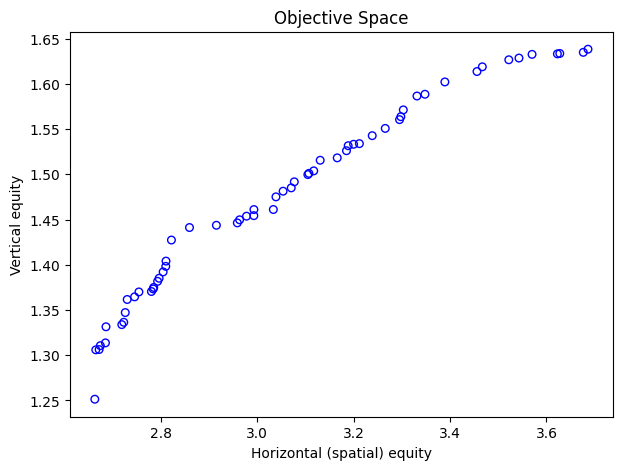

In [10]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], -F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel("Horizontal (spatial) equity")
plt.ylabel("Vertical equity")
plt.show()

Convergence (beta=0.01)

In [11]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

hist = res.history
for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)
    algo.n_gen

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

At least one feasible solution in Generation 11 after 1200 evaluations.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


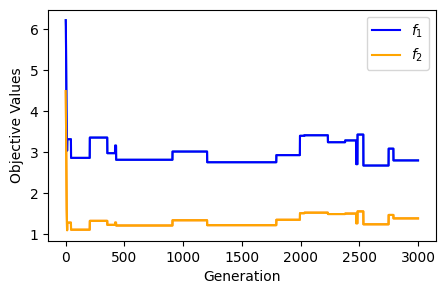

In [12]:
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval / 100 for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])
opt[:, 1] = -opt[:, 1]

plt.figure(figsize=(5, 3))

plt.plot(n_evals, opt)
plt.xlabel("Generation")
plt.ylabel("Objective Values")
plt.plot(n_evals, opt[:, 0], color='blue', label='$f_1$')
plt.plot(n_evals, opt[:, 1], color='orange', label='$f_2$')
plt.legend()
plt.savefig("convergence_obj.eps", format="eps", bbox_inches='tight')
plt.show()

Whole population feasible in Generation 98 after 99.0 evaluations.


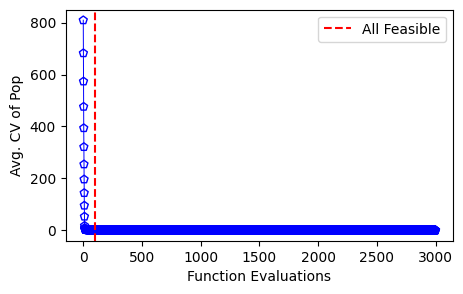

In [13]:
# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(5, 3))
plt.plot(n_evals, vals,  color='blue', lw=0.7)
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='blue', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.xlabel("Function Evaluations")
plt.ylabel("Avg. CV of Pop")
plt.legend()
# plt.savefig("convergence_cv.eps", format="eps", bbox_inches='tight')
plt.show()

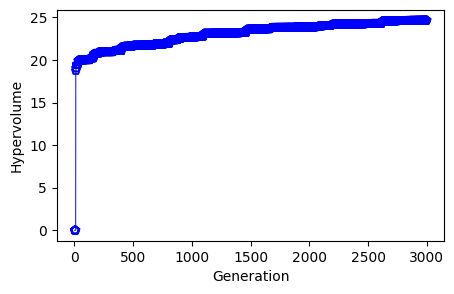

In [22]:
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
metric = Hypervolume(ref_point= np.array([5, 5]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)
n_evals = np.array([e.evaluator.n_eval / 100 for e in res.history])
hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(5, 3))
plt.plot(n_evals, hv,  color='blue', lw=0.7)
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='blue', marker="p")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.savefig("convergence_pf.eps", format="eps", bbox_inches='tight')
plt.show()